# Assignment 3&4
## Part 2: PM4PY
## Group D

In [1]:
!pip install pm4py

## Load packages

In [7]:
import pm4py
import pandas as pd
import statistics
import numpy as np
from pm4py.statistics.traces.generic.log import case_statistics

## Define the event log

In [99]:
def import_csv(file_path):
    event_log = pd.read_csv(file_path, sep=',') #read csv file into pandas
    print(event_log.head())  #print top rows
    event_log = event_log.rename(columns={'Case ID': 'case_ID'})
    event_log = pm4py.format_dataframe(event_log, case_id='case_ID', 
                                       activity_key='Activity', 
                                       timestamp_key='Complete Timestamp') #annotate from csv into pm4py format
    num_events = len(event_log)
    num_activ_unq = len(event_log.Activity.unique())
    num_cases = len(event_log.case_ID.unique())
    num_variants = len(pm4py.get_variants_as_tuples(event_log))
    
    print('\033[1m'+"\nEVENT LOG SUMMARY: "+'\033[0m')
    
    print("\nNumber of events: {}\nNumber of unique activities: {}\nNumber of cases: {}\nNumber of variants: {}\n".format(num_events,num_activ_unq, num_cases,num_variants))

    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}\n".format(start_activities, end_activities))
    
    pm4py.view_events_distribution_graph(event_log, distr_type="years")
    
    return event_log

## Import the csv file and get basic summary

     Case ID                Activity Complete Timestamp     Variant  \
0  332114754               Reception   2016-04-08 22:38  Variant 39   
1  332114754         Nurse admission   2016-04-08 22:57  Variant 39   
2  332114754       Additional vitals   2016-04-08 22:58  Variant 39   
3  332114754  Last lab tests results   2016-04-08 23:21  Variant 39   
4  332114754        Doctor admission   2016-04-08 23:33  Variant 39   

   Variant index  
0             39  
1             39  
2             39  
3             39  
4             39  

EVENT LOG SUMMARY: 

Number of events: 461839
Number of unique activities: 15
Number of cases: 55079
Number of variants: 9537

Start activities: {'Reception': 55076, 'Doctor admission': 1, 'Nurse admission': 1, 'Last lab tests results': 1}
End activities: {'Discharge': 55079}



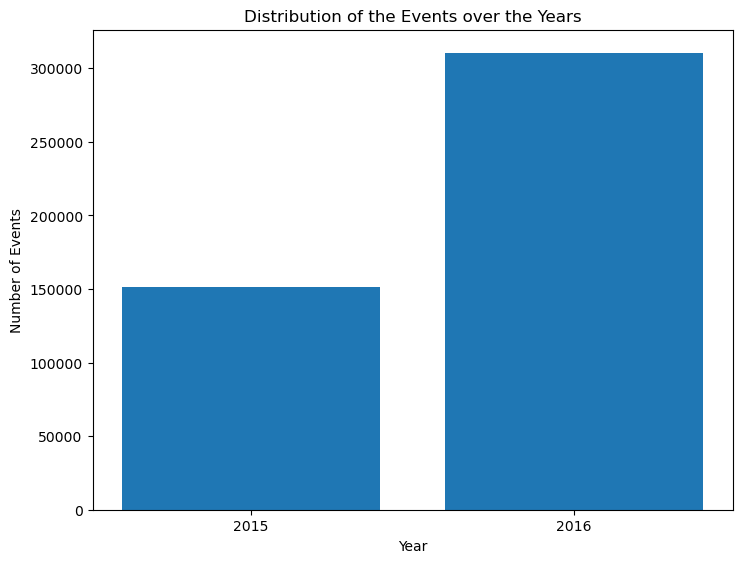

In [100]:
event_log = import_csv("carmel_data.csv")

## Most Common Variants

In [38]:
variants = pm4py.get_variants_as_tuples(event_log)

v_len = len(variants)

print(f"There are: {v_len} variants in the log\n")
print('\033[1m'+"Here are the top-5 variants:"+'\033[0m')

variants_count = case_statistics.get_variant_statistics(event_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

variants_count[:5]

There are: 9537 variants in the log

Here are the top-5 variants:


[{'variant': ('Reception',
   'Nurse admission',
   'Order blood tests',
   'Last lab tests results',
   'Doctor admission',
   'Discharge (Doctor)',
   'Discharge'),
  'count': 7994},
 {'variant': ('Reception',
   'Nurse admission',
   'Doctor admission',
   'Discharge (Doctor)',
   'Discharge'),
  'count': 5015},
 {'variant': ('Reception',
   'Nurse admission',
   'Order blood tests',
   'Doctor admission',
   'Last lab tests results',
   'Discharge (Doctor)',
   'Discharge'),
  'count': 4613},
 {'variant': ('Reception',
   'Nurse admission',
   'Last lab tests results',
   'Doctor admission',
   'Discharge (Doctor)',
   'Discharge'),
  'count': 3389},
 {'variant': ('Reception',
   'Nurse admission',
   'Doctor admission',
   'Last lab tests results',
   'Discharge (Doctor)',
   'Discharge'),
  'count': 2744}]

We see that all top 5 frequent variants start with Reception followed by Nurse admission.  
In addition, all top 5 variants end with Discharge by a doctor followed by general Discharge.

Let's now assess how representative is each variant in regards to the log.

In [67]:
num_cases = len(event_log.case_ID.unique())
print("First variant represents",round(100*(7994/num_cases),2),"% of cases.")
print("Second variant represents",round(100*(5015/num_cases),2),"% of cases.")
print("Third variant represents",round(100*(4613/num_cases),2),"% of cases.")
print("Fourth variant represents",round(100*(3389/num_cases),2),"% of cases.")
print("Fifth variant represents",round(100*(2744/num_cases),2),"% of cases.")

First variant represents 14.51 % of cases.
Second variant represents 9.11 % of cases.
Third variant represents 8.38 % of cases.
Fourth variant represents 6.15 % of cases.
Fifth variant represents 4.98 % of cases.


## Most Common Events

In [109]:
print("Number of cases: ",num_cases)
events = event_log.groupby(['Activity'])['case_ID'].describe().drop(['mean','std','min','25%','50%','75%','max'],axis = 1).sort_values(by='count',ascending=False).rename(columns = {'count':'Count of Occurences'})
events['% of Cases'] = round(100*(events['Count of Occurences']/num_cases),2)
events

Number of cases:  55079


Count of Occurences  % of Cases
Activity                                               
Discharge                           55079.0      100.00
Reception                           55079.0      100.00
Doctor admission                    54871.0       99.62
Nurse admission                     54300.0       98.59
Discharge (Doctor)                  54213.0       98.43
Last lab tests results              41268.0       74.93
Order Imaging test                  29730.0       53.98
Order blood tests                   28043.0       50.91
Imaging                             27824.0       50.52
Additional vitals                   25188.0       45.73
Order Consultant                    15192.0       27.58
Consultant                          12954.0       23.52
Imaging decrypting                   7110.0       12.91
Order external exams                  506.0        0.92
External exams                        482.0        0.88

Discharge and Reception happenned in all cases. 
  
The next two most common events were Doctors Admission (in 99.62% of cases) and Nurse Admission (in 98.59% of cases).  
  
The least common events were External Exams and Ordering External Exams happenning in less than 1% of cases.  
  
Ordering Imaging Test, Ordering Blood Results and Imaging happenned for roughly 50% of patient cases.

# Time Perspective Statistics

## 1. Average duration of cases

In [62]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%2d:%2d" % (hour, minutes, seconds)

In [63]:
all_case_durations = pm4py.get_all_case_durations(event_log)

average_duration = statistics.mean(all_case_durations)

day = average_duration // (24 * 3600)
average_duration = average_duration % (24 * 3600)
hour = average_duration // 3600
average_duration %= 3600
minutes = average_duration // 60
average_duration %= 60
seconds = round(average_duration, 2)

print(f"Average duration of all cases: {day} days, {hour} hours, {minutes} minutes, {seconds} seconds.")

Average duration of all cases: 0.0 days, 7.0 hours, 56.0 minutes, 46.16 seconds.


## 2. Average duration of events

### Let's enrich our log with timestamps for case start, case end, relative time of events

In [64]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = event_log.pivot_table(index='case_ID', aggfunc={'Complete Timestamp': ['min', 'max']}) 
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['case_ID', 'caseend', 'casestart'] 

# Merge with the main event log data so that for each row we have the start and end times:
event_log_1 = event_log.merge(case_starts_ends, on='case_ID') 

# Calculate the relative time by subtracting the process start time from the event timestamp:
event_log_1['relativetime'] = event_log_1['Complete Timestamp'] - event_log_1['casestart']

# Convert relative times to more friendly measures:
## seconds
event_log_1['relativetime_s'] = event_log_1['relativetime'].dt.seconds + 86400*event_log_1['relativetime'].dt.days 
## days
event_log_1['relativedays'] = event_log_1['relativetime'].dt.days


# Calculate duration of each event:
event_log_1
# For each column, add relative time of previous 
event_log_1['relativetime_s_prev'] = event_log_1['relativetime_s'].shift(1)

event_log_1['duration'] = event_log_1['relativetime_s'] - event_log_1['relativetime_s_prev']
event_log_1['duration'] = event_log_1['duration'].fillna(0)
event_log_1['duration'] = event_log_1['duration'].clip(lower=0)
# df['A'] = df['A'].map(addOne)

event_log_1[["case_ID","Activity","caseend","casestart","relativetime_s","relativetime_s_prev","duration"]]

case_ID                Activity                   caseend  \
0       332040365               Reception 2015-12-31 21:45:00+00:00   
1       332040365         Nurse admission 2015-12-31 21:45:00+00:00   
2       332040365       Order blood tests 2015-12-31 21:45:00+00:00   
3       332040365  Last lab tests results 2015-12-31 21:45:00+00:00   
4       332040365        Doctor admission 2015-12-31 21:45:00+00:00   
...           ...                     ...                       ...   
461834  332152317      Order Imaging test 2016-08-31 21:01:00+00:00   
461835  332152317                 Imaging 2016-08-31 21:01:00+00:00   
461836  332152317      Imaging decrypting 2016-08-31 21:01:00+00:00   
461837  332152317      Discharge (Doctor) 2016-08-31 21:01:00+00:00   
461838  332152317               Discharge 2016-08-31 21:01:00+00:00   

                       casestart  relativetime_s  relativetime_s_prev  \
0      2015-12-31 13:42:00+00:00               0                  NaN   
1      2015-12-31 13:42:00+00:00            2100                  0.0   
2      2015-12-31 13:42:00+00:00            2160               2100.0   
3      2015-12-31 13:42:00+00:00            3060               2160.0   
4      2015-12-31 13:42:00+00:00            6360               3060.0   
...                          ...             ...                  ...   
461834 2016-08-31 15:11:00+00:00            8040               7920.0   
461835 2016-08-31 15:11:00+00:00           11820               8040.0   
461836 2016-08-31 15:11:00+00:00           15360              11820.0   
461837 2016-08-31 15:11:00+00:00           16020              15360.0   
461838 2016-08-31 15:11:00+00:00           21000              16020.0   

        duration  
0            0.0  
1         2100.0  
2           60.0  
3          900.0  
4         3300.0  
...          ...  
461834     120.0  
461835    3780.0  
461836    3540.0  
461837     660.0  
461838    4980.0  

[461839 rows x 7 columns]

In [65]:
description = event_log_1.groupby(['Activity'])['duration'].describe().drop(['std','25%','50%','75%','min'],axis = 1).rename(columns = {"mean": "Average Delay","max":"Max Delay"}).sort_values(by='count',ascending=False)
description['Average Delay'] = description['Average Delay'].map(convert)
description['Max Delay'] = description['Max Delay'].map(convert)
description.sort_values(by='Average Delay')

count Average Delay Max Delay
Activity                                               
Reception               55079.0       0: 0: 0   0:13: 0
Order blood tests       28043.0       0: 2:53  16:59: 0
Order Imaging test      29730.0       0:25:47  23:41: 0
Last lab tests results  41268.0       0:27:44  16:15: 0
Doctor admission        54871.0       0:34:45  21:59: 0
Imaging                 27824.0       0:44:14  23:41: 0
Imaging decrypting       7110.0       0:46:16   2:42: 0
Order Consultant        15192.0       0:48:25   0:14: 0
Nurse admission         54300.0       0:49:23   2:38: 0
Consultant              12954.0       0:59:39  20:35: 0
Additional vitals       25188.0       1:10: 0  11:38: 0
Discharge               55079.0       1:46:22  20:52: 0
Discharge (Doctor)      54213.0       2:42:32  22:25: 0
Order external exams      506.0       2:53:45  20:15: 0
External exams            482.0       3: 2:22  10:50: 0

Times are shown in hh:mm:ss format

#### Calculation Notes
Average Delay column shows us the average duration + delays between ativities.  
We can't calculate the exact duration of events due to lack of Start and End timestapms in the original csv.  
  
#### Shortest Activities
Ordering a blood test has the shortest delay, just about 3 minutes on average. Ordering imaging test and getting last lab test results are the next two shortest activities by delay, roughly averaging around 30 mins.
  
#### Longest Activities  
External exams and ordering external exams has the longest delay, averaging around 3 hours. Discharge by a doctor and general discharge are the next longest, averaging 2h 43 mins and 1h 46 mins correspondingly.

####   Start and End Activities
We see that Reception and Discharge are the two activities that have happended for all cases (55,079 times). While we don't know the duration of reception, disharge activity on average takes 1 hour 46 minutes. This most likely means that while discharge doesn't take that long to complete rather there is a big delay between the last activity performed on a patient and the discharge.

### Eventually-Follows Graphs

Each line represents the activities that are eventually followed after another activity.  
It also shows the count of variants.

In [16]:
efg_graph = pm4py.discover_eventually_follows_graph(event_log)

In [28]:
sorted_value_index = np.argsort(efg_graph.values())
dictionary_keys = list(efg_graph.keys())
sorted_efg_graph = {dictionary_keys[i]: sorted(
    efg_graph.values(),reverse=True)[i] for i in range(len(dictionary_keys))}
 
sorted_efg_graph

{('Additional vitals', 'Additional vitals'): 55079,
 ('Additional vitals', 'Consultant'): 54871,
 ('Additional vitals', 'Discharge'): 54869,
 ('Additional vitals', 'Discharge (Doctor)'): 54300,
 ('Additional vitals', 'Doctor admission'): 54299,
 ('Additional vitals', 'External exams'): 54213,
 ('Additional vitals', 'Imaging'): 54213,
 ('Additional vitals', 'Imaging decrypting'): 54198,
 ('Additional vitals', 'Last lab tests results'): 53222,
 ('Additional vitals', 'Nurse admission'): 52271,
 ('Additional vitals', 'Order Consultant'): 41268,
 ('Additional vitals', 'Order Imaging test'): 41266,
 ('Additional vitals', 'Order blood tests'): 39967,
 ('Additional vitals', 'Order external exams'): 39840,
 ('Consultant', 'Additional vitals'): 38169,
 ('Consultant', 'Consultant'): 29730,
 ('Consultant', 'Discharge'): 29730,
 ('Consultant', 'Discharge (Doctor)'): 28566,
 ('Consultant', 'Doctor admission'): 28449,
 ('Consultant', 'External exams'): 28043,
 ('Consultant', 'Imaging'): 28042,
 ('Con

### Events distribution

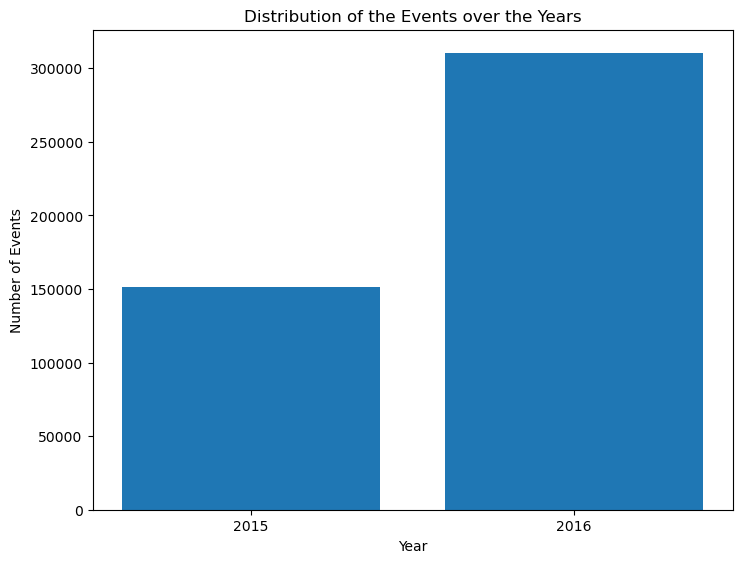

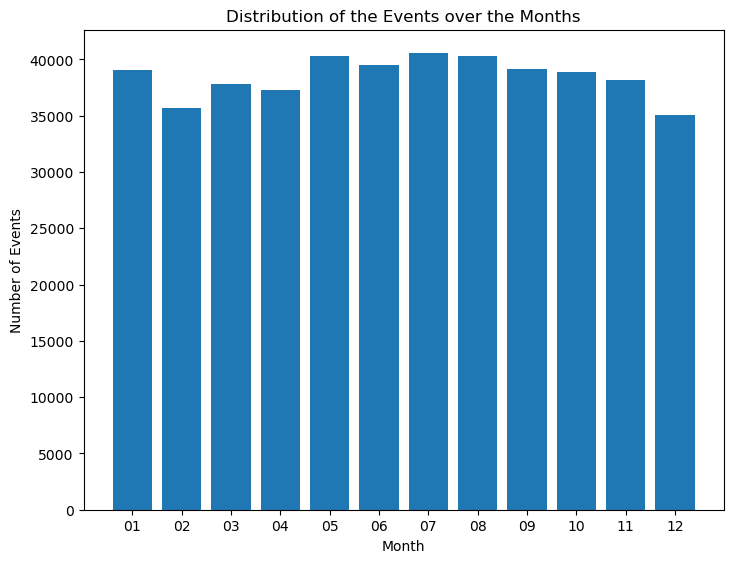

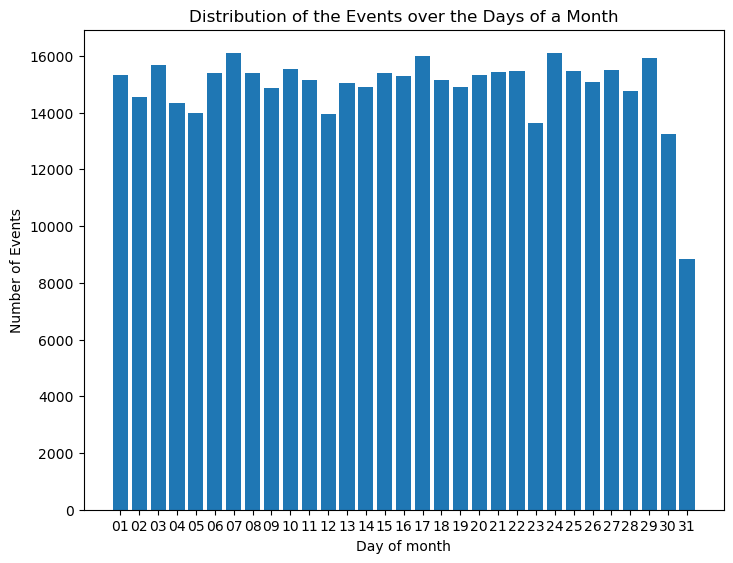

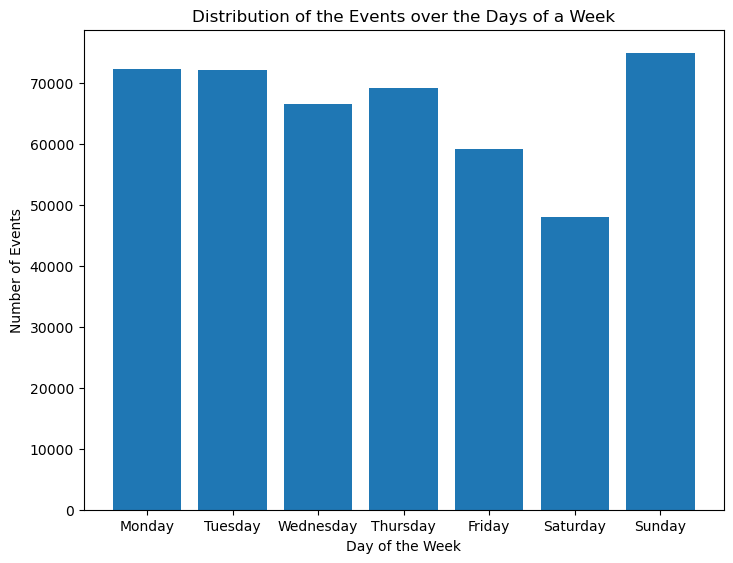

In [35]:
pm4py.view_events_distribution_graph(event_log, distr_type="years")
pm4py.view_events_distribution_graph(event_log, distr_type="months")
pm4py.view_events_distribution_graph(event_log, distr_type="days_month")
pm4py.view_events_distribution_graph(event_log, distr_type="days_week")

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(event_log)

In [ ]:
tree = pm4py.discover_process_tree_inductive(event_log)
#tree = pm4py.convert_to_process_tree(net, initial_marking, final_marking)
bpmn_model = pm4py.convert_to_bpmn(tree)
pm4py.view_bpmn(bpmn_model)

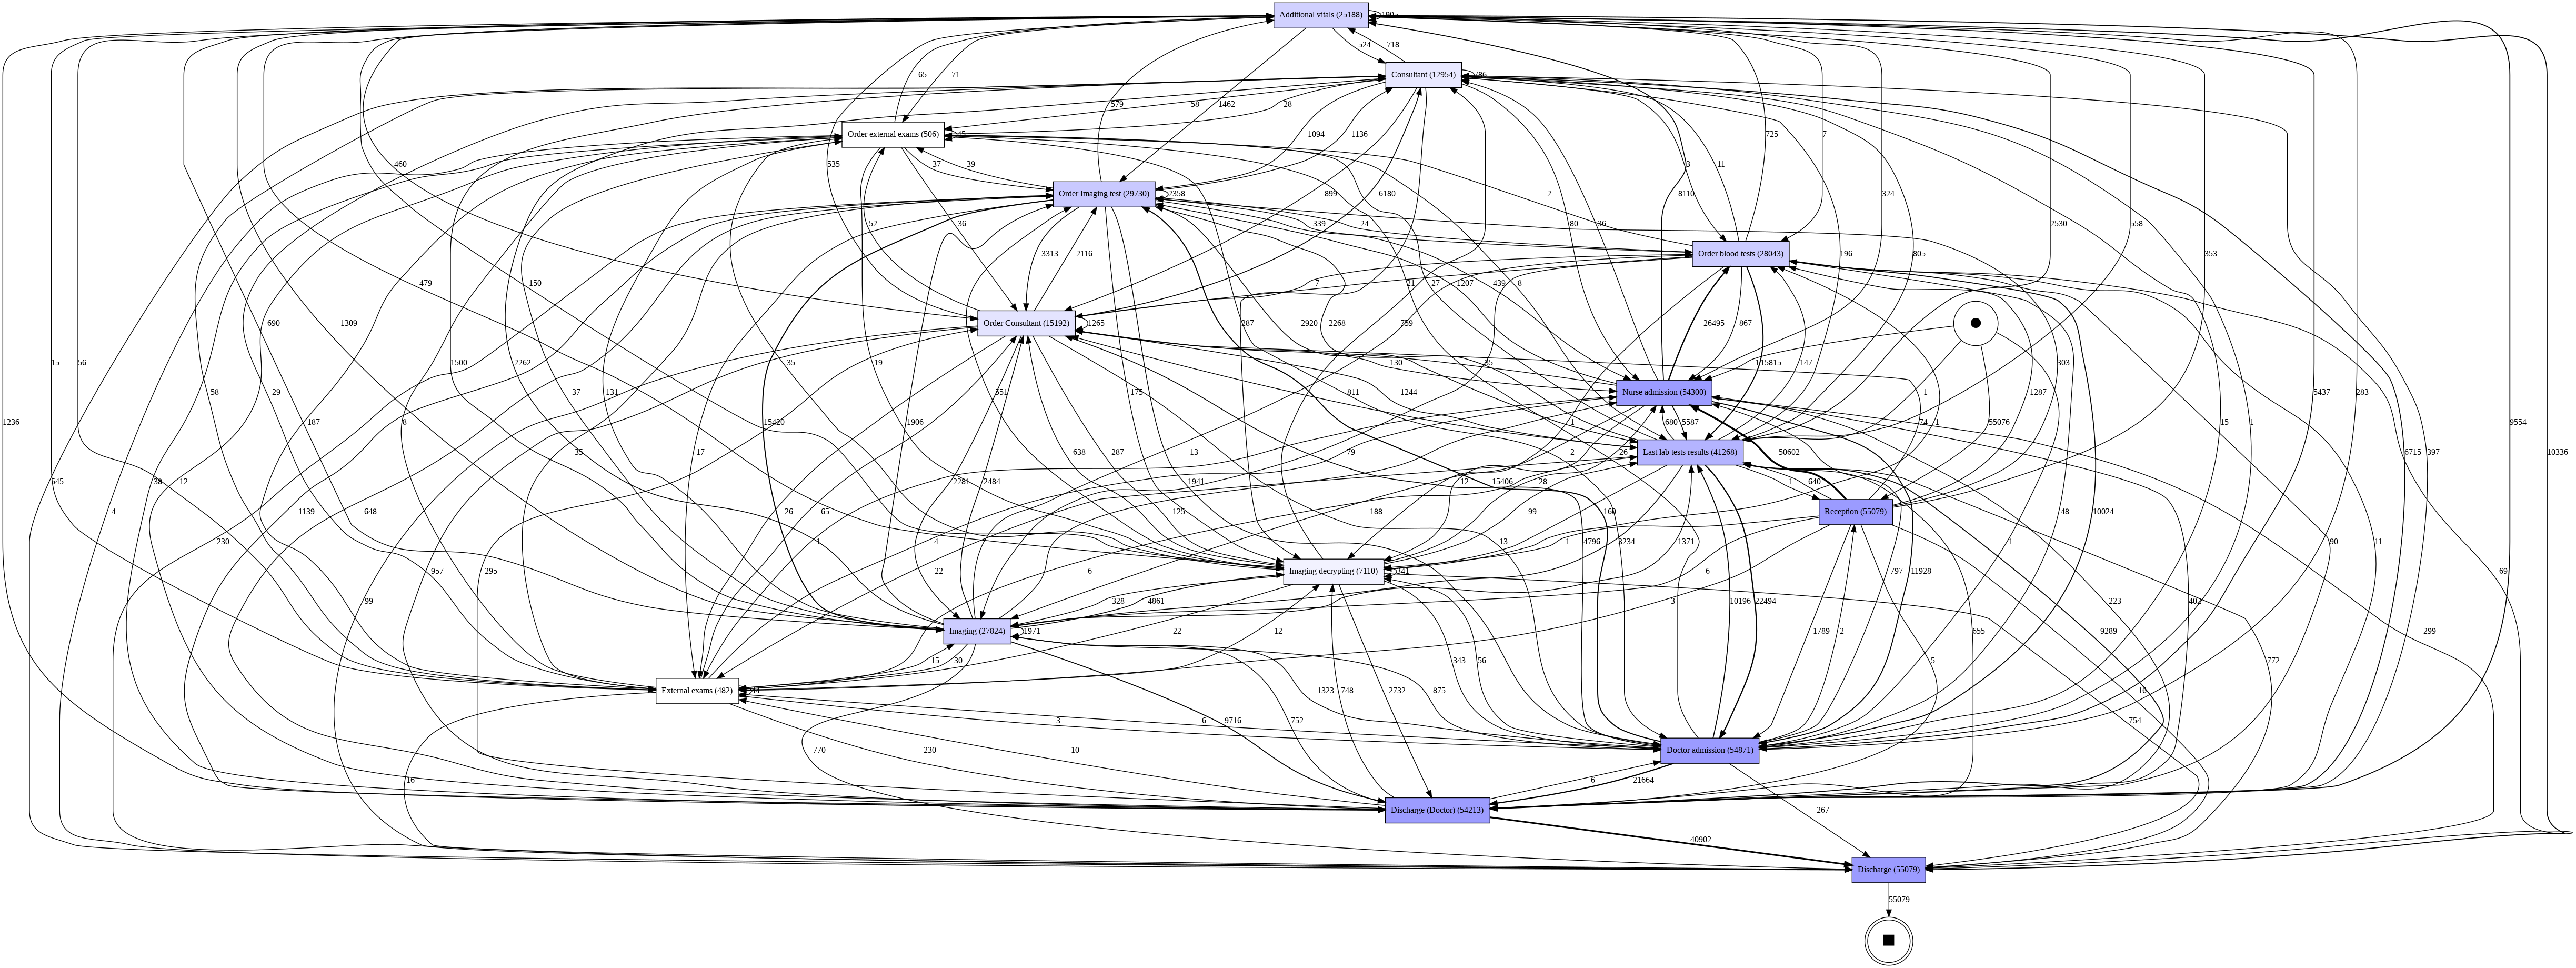

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

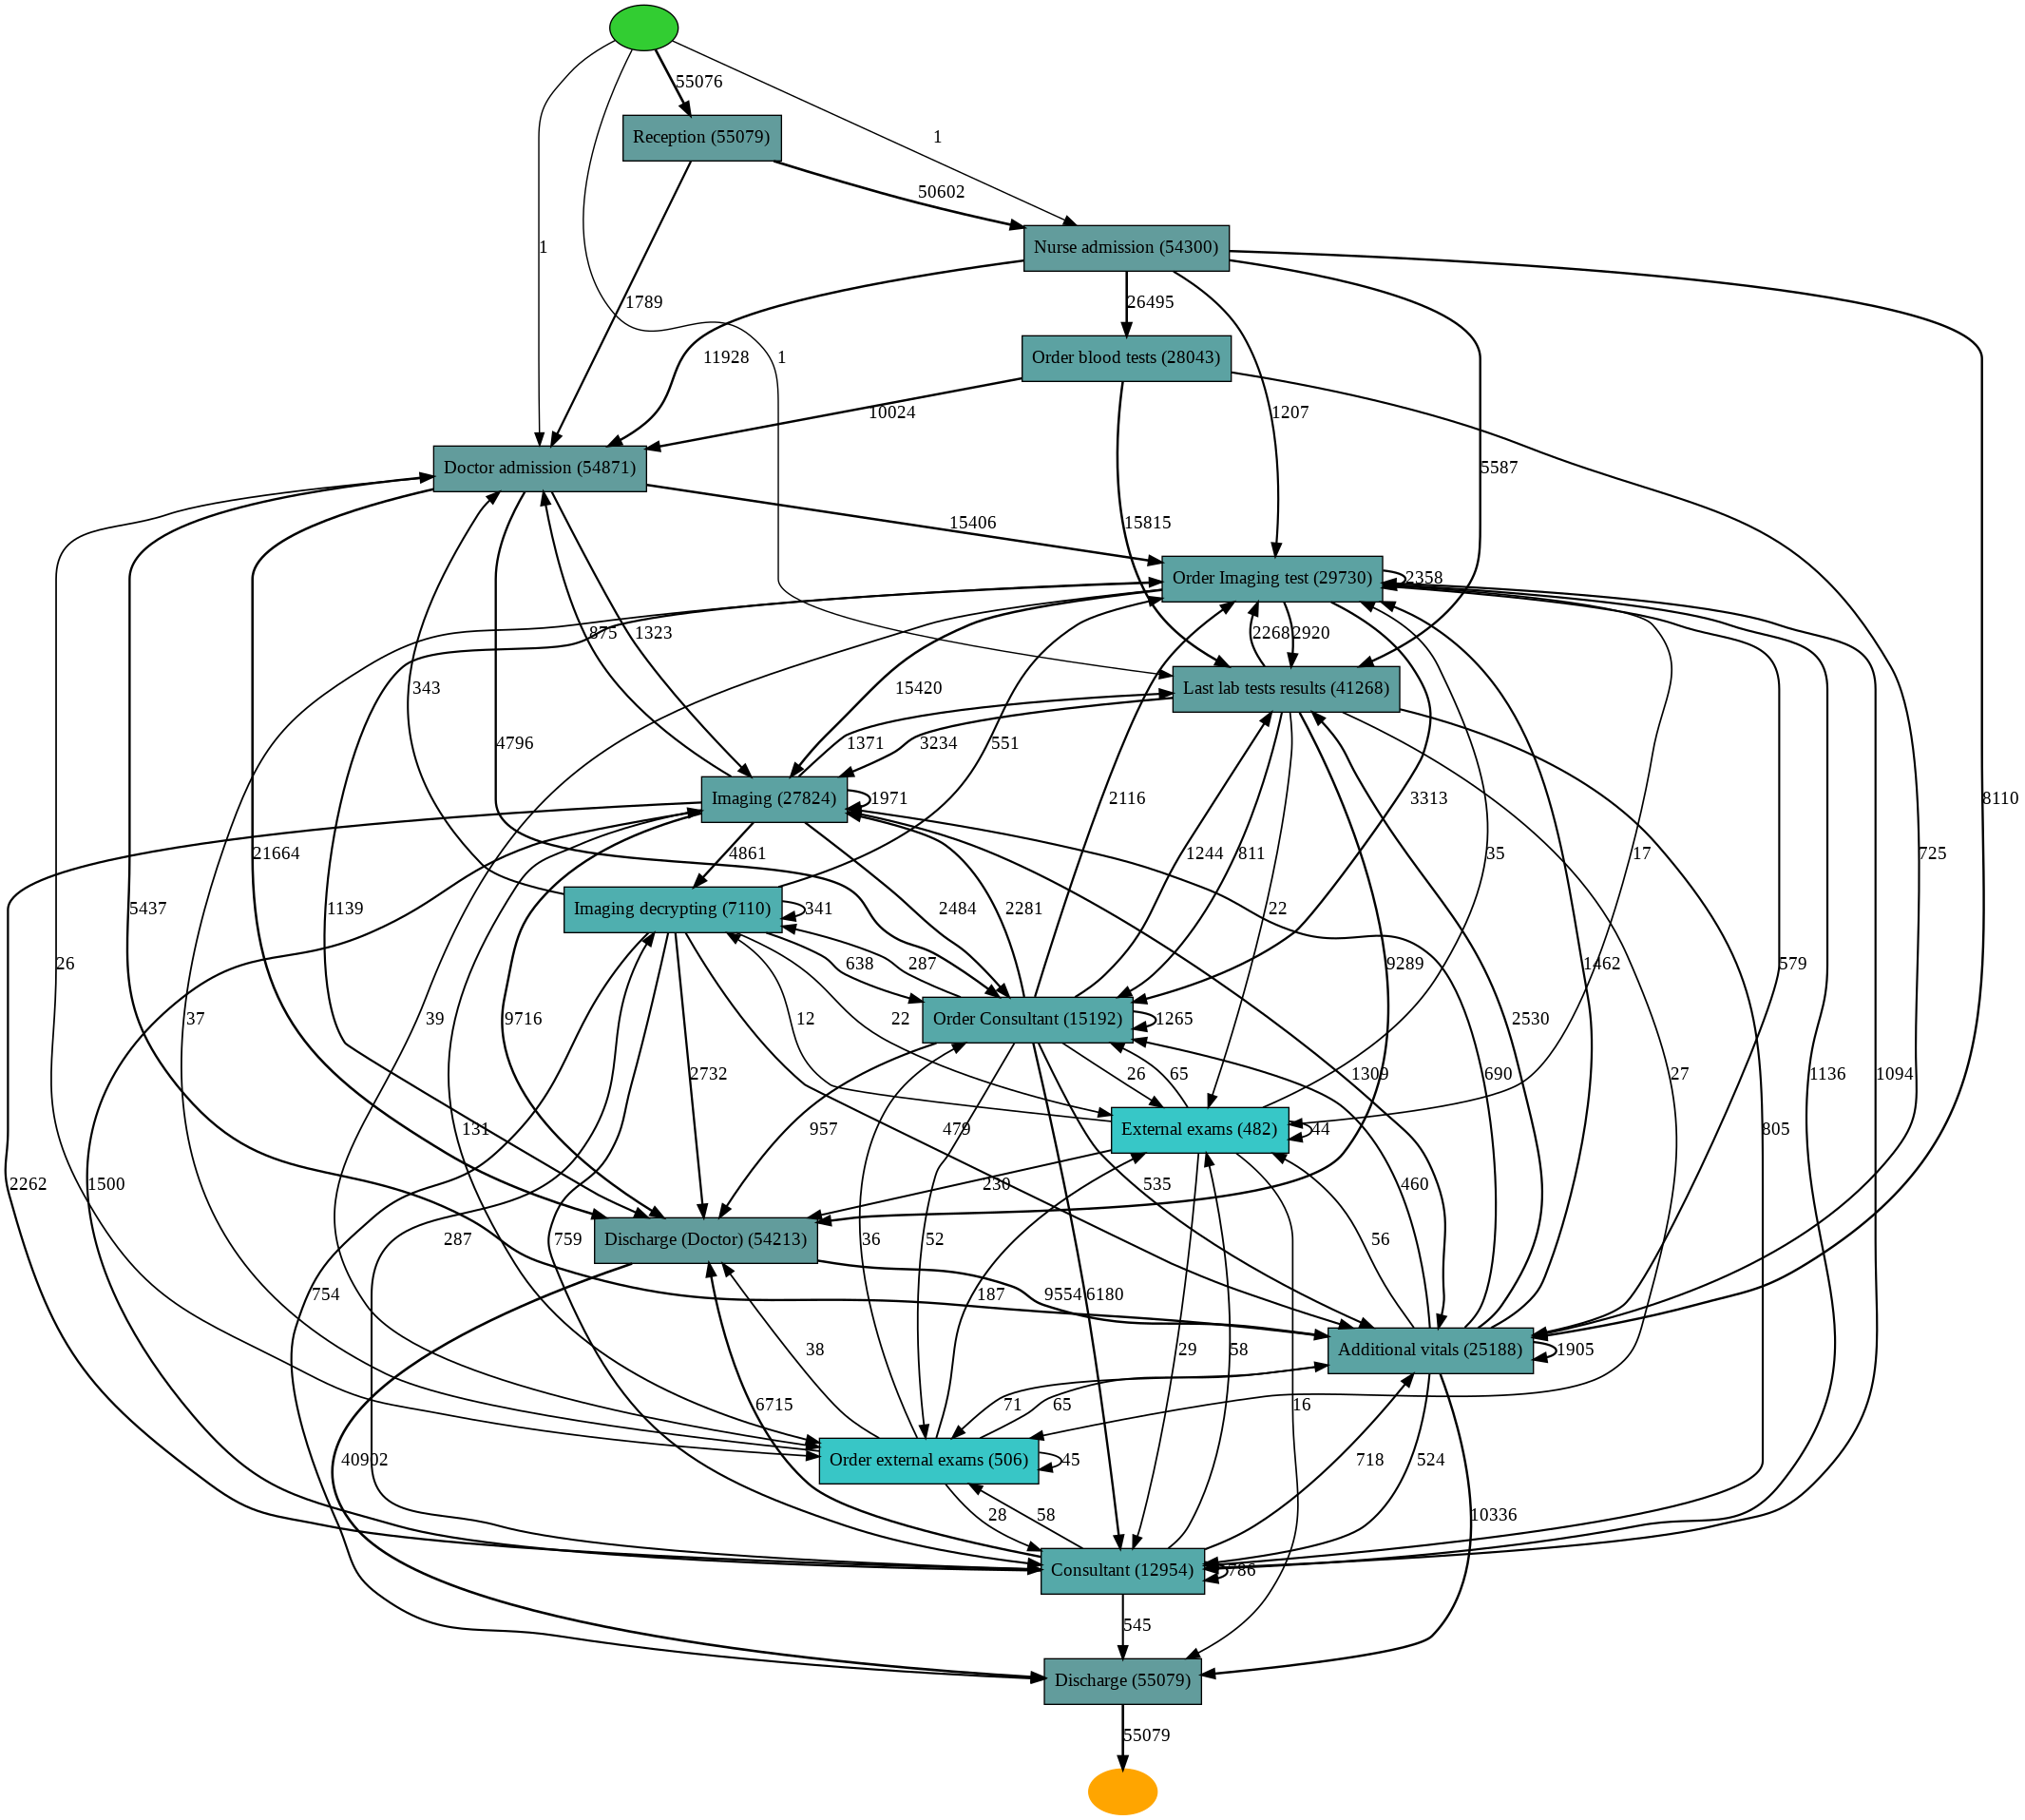

In [ ]:
map = pm4py.discover_heuristics_net(event_log)
pm4py.view_heuristics_net(map)

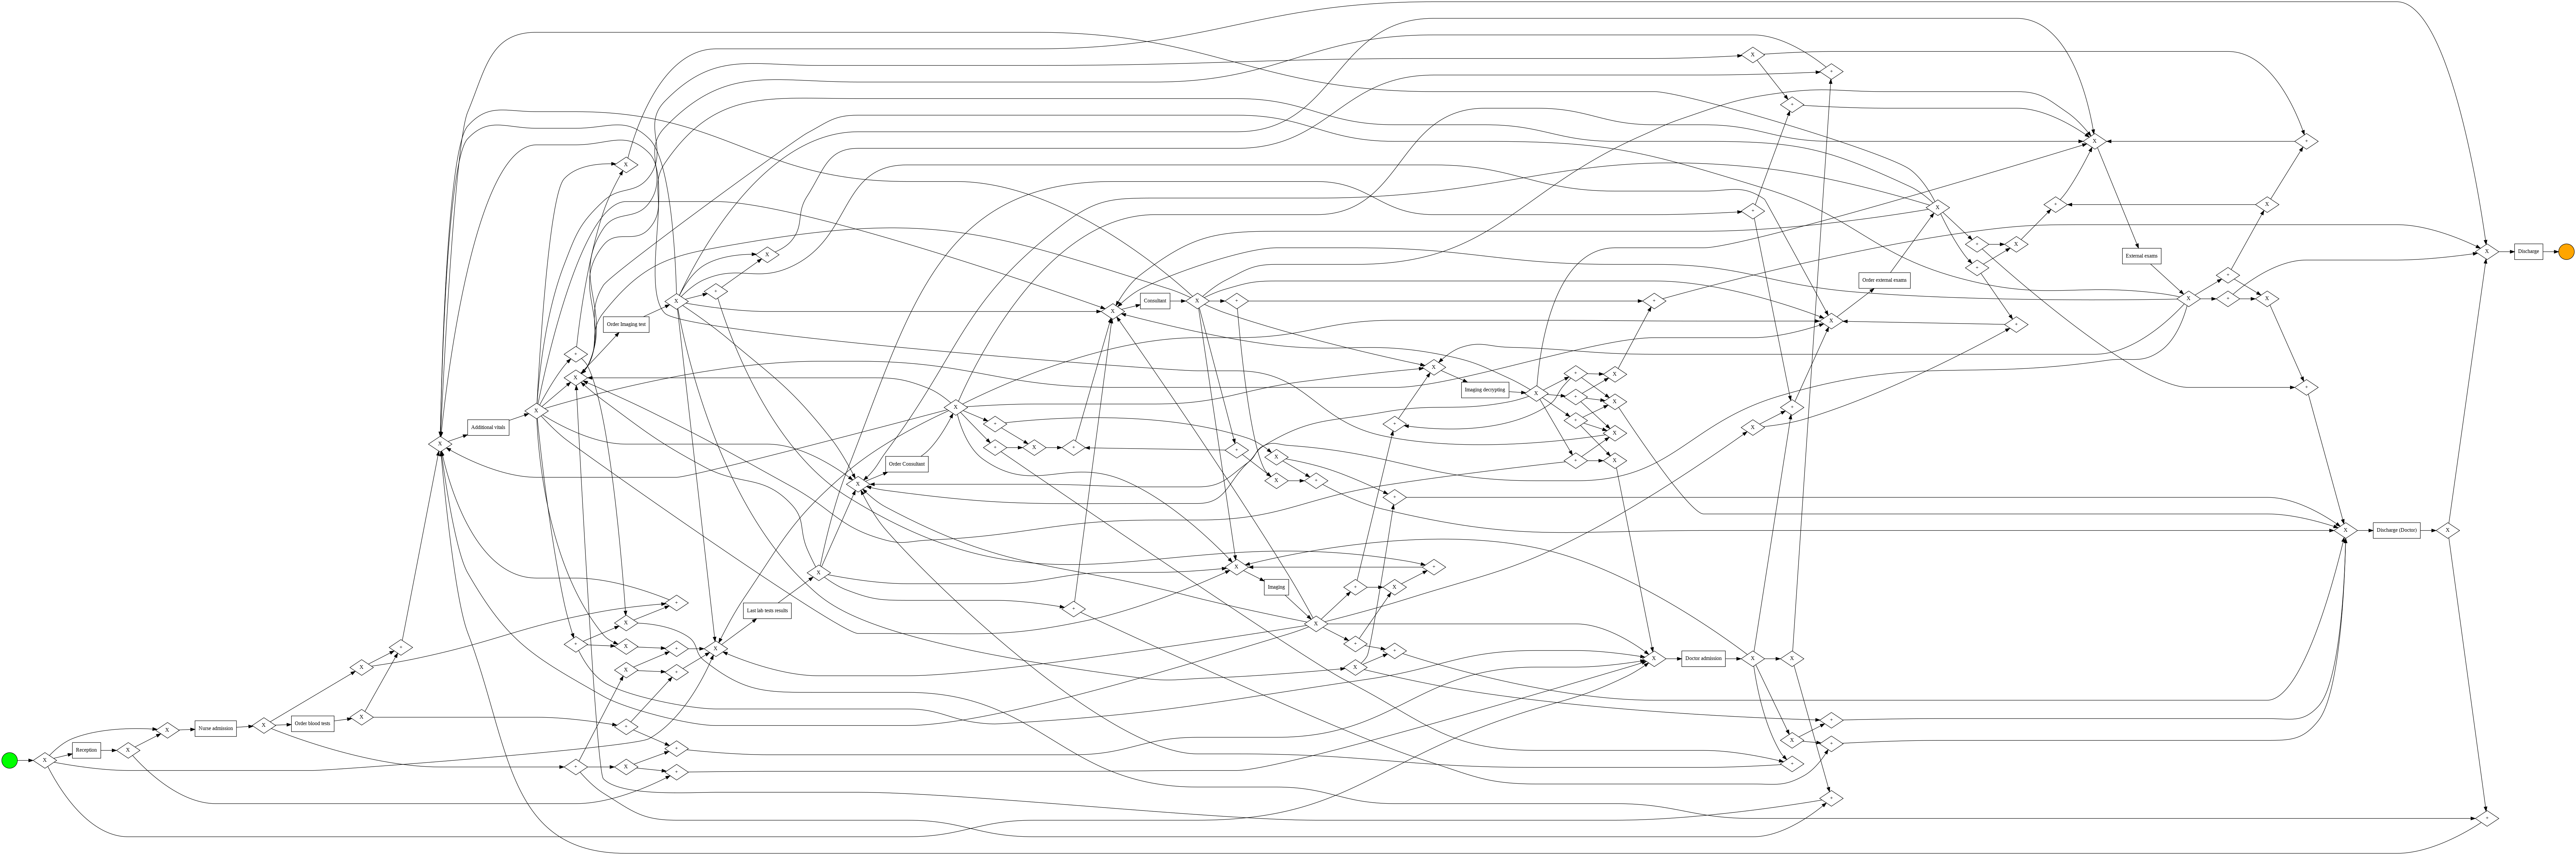

In [ ]:
bpmn_model = pm4py.convert_to_bpmn(map)
pm4py.view_bpmn(bpmn_model)

In [ ]:
#convert to XES:
pm4py.write_xes(event_log, 'carmel_xes.xes')

exporting log, completed traces ::   0%|          | 0/55079 [00:00<?, ?it/s]